# Import Packages

# Ιδεα ρίξε το βάρος της νέας δημοκρατίας ΄ψαξε : πώς κάνω το μοντελο μ ποιο ισοσκελές

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

#From Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#Import Seaborn
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
sns.set_context("poster")

#From Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# https://stackoverflow.com/questions/51111954/tensorflow-cant-find-cudart64-90-dll-even-though-it-is-installed-with-path-va/51112550

# Load the Data

In [39]:
df = pd.read_excel('DataAfterSampling.xls')
df = shuffle(df)

# Shape of the Data

In [40]:
df.shape

(33119, 143)

# Remove Duplicates

In [41]:
# df = df.drop_duplicates()
len(df)

33119

# Fill some obvious NaN

In [42]:
df['nkids'].fillna('Κανένα', inplace = True)

# Fill numerical NaN with the mean of each collumn 

In [43]:
columns_with_nan = df.columns[df.isnull().mean() != 0].tolist()

for col in columns_with_nan:
    if ( df[col].dtype != object ):
        df[col].fillna( df[col].mean(),inplace = True)

# Fill NaN at object type columns with the prevailing value of each column

In [44]:
for col in columns_with_nan:
    if ( df[col].dtype == object ):
        df[col].fillna( df[col].value_counts().index[0],inplace = True)

# Remove columns with NaN

## Normally we souldnt' have any

In [45]:
print(len(df.columns))
columns_with_few_nan = df.columns[df.isnull().mean() == 0].tolist()
df = df[columns_with_few_nan]
len(df.columns)

143


143

# Print Columns with NaN

In [46]:
columns_with_nan = df.columns[df.isnull().mean() != 0].tolist()
print(columns_with_nan)

[]


# Print all the remaining columns

In [47]:
for column in df.columns:
    print (column) 

id
code
age
sex
education
kids
nkids
live
religious
job
sector
kindofjob
coordinator
numemployees
income
soclass
bus.sector
experience.last
experience
contract
fullpart
contract2
aggreement
unionmember
kindofunion
wwemployer
Q31.redundancy
Q31.laborrights
Q31.interests
Q31.employerinterests
Q31.trust
Q31.GSEErights
Q31.GSEEtrust
Q31.GSEEservegovernment
Q31.unionaffectgovernment
Q31.unionpower
union.f1
union.f2
mentalmanualwork
unionmembervisit
Q43.unemployed
Q43.independent
Q43.varietyofactivities
Q43.identifiability
Q43.bossbehavior
Q43.bossabilitytodecision
Q43.conscience
Q43.jobstability
Q43.offertoother
Q43.guideother
Q43.usequalifications
Q43.companypolicy
Q43.salary
Q43.promotionopportunity
Q43.judjmentfreedom
Q43.applymyideas
Q43.workingconditions
Q43.relationships
Q43.awareness
Q43.completion
q43.satisfaction.f1
q43.satisfaction.f2
q43.satisfaction.f3
Q63.emotionallydrained
Q63.exhaustion
Q63.tiredness
Q63.pressure
Q63.effectiveness
Q63.exhaustion2
Q63.contribution
Q63.interest

# Remove Useless columns

In [48]:
to_drop = ['id', 'code']
df = df.drop(to_drop, axis = 1)

# Separate the Dataset -> Indecisive and Decisive

In [49]:
#Indecisive
condition = df['election'] == 'Αναποφάσιστος'
indecisives = df[condition]
print ('Number of indecisives: {}'.format(indecisives.shape[0]))

#decisive
condition = df['election'] != 'Αναποφάσιστος'
decisives = df[condition]
print ('Number of decisives: {}'.format(decisives.shape[0]))

Number of indecisives: 10620
Number of decisives: 22499


# Encode the features

In [50]:
#Columns for encoding - Non numerical columns

g = df.columns.to_series().groupby(df.dtypes).groups
keys = g.keys()
objects = list(keys)[2]

columns_for_encoding = g[objects].tolist()

In [51]:
def encode(str_column):
    encoder = LabelEncoder()
    fitted_encoder = encoder.fit(df[str_column])
    return fitted_encoder

for column in columns_for_encoding:
    fitted_encoder = encode(column)
    indecisives[column] = fitted_encoder.transform(indecisives[column].astype(str))
    decisives[column] =fitted_encoder.transform(decisives[column].astype(str))
    if column == 'election':
        election_encoder = fitted_encoder

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Export as Csv For Weka

In [52]:
decisives.to_csv('ForWeka.csv', sep=',')

# Create Train - Test Sets

In [53]:
x_train = decisives.drop('election', axis = 1)
x_train.to_csv('x_train.csv')

y_train = decisives[['election']]
y_train.to_csv('y_train.csv')

#Make them catecogrical - one hot. That means that if we have 10 classes it will be an array with an 1 at the corresponding pos.
y_train = np_utils.to_categorical(y_train)

for_prediction = indecisives.drop('election', axis = 1)
for_prediction.to_csv('for_prediction.csv')

In [54]:
y_train.shape

(22499, 15)

# Normalization

In [55]:
scaler = MinMaxScaler()
fitted_scaler = scaler.fit(x_train)

x_train = scaler.transform(x_train)
for_prediction = scaler.transform(for_prediction)

# Define the model

In [73]:
#Define callbacks
callbacks = [

                    keras.callbacks.EarlyStopping(monitor='loss',patience=10),
                    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10),
                    keras.callbacks.ModelCheckpoint(filepath='indecisives_model.h5', monitor='val_loss',save_best_only=True),
                    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3),
        ]

#define main model
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.043280113058326644))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2583555659114839))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.16253753533176135))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.07801335043578438))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.044173345888581))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.02536677742676327))

model.add(Dense(y_train.shape[1], activation='softmax'))
model.summary()

# Compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_split = 0.25,callbacks=callbacks, shuffle=True)

model.load_weights("indecisives_model.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 256)               36096     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
__________

# Plot Validation loss

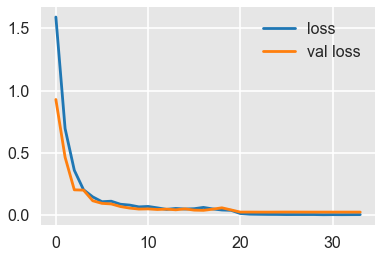

In [74]:
#plot also the loss function
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Plot Accuracy 

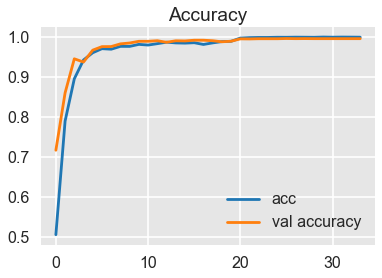

In [75]:
#plot also the loss function
plt.title('Accuracy')
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val accuracy')
plt.legend()
plt.show()

# Plot our training Data

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


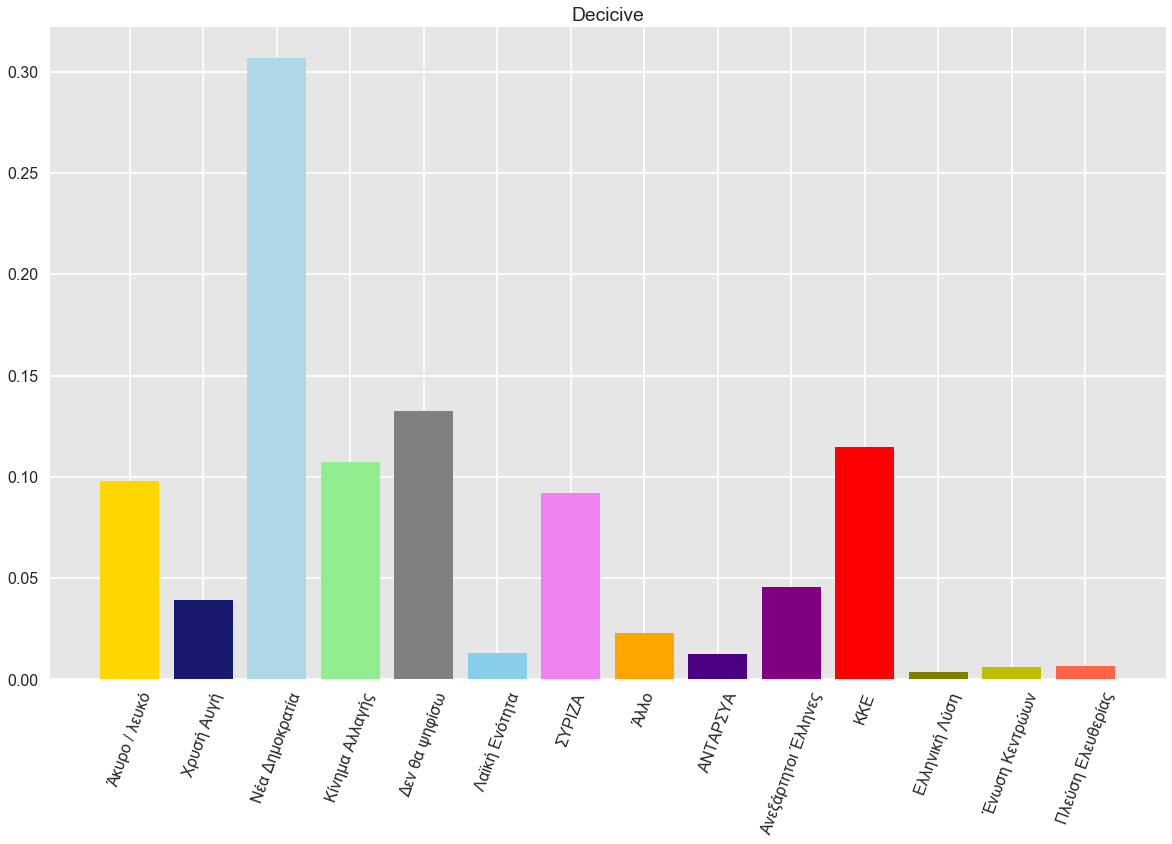

In [94]:
prediction = y_train

predictions = []
for i in prediction:
    predictions.append(np.argmax(i))

    
count = Counter(election_encoder.inverse_transform(predictions))

labels = []
sizes = []
for key, value in count.items():
    
    labels.append(key)
    sizes.append(value/sum(count.values()))
    

plt.figure(figsize=(20,12))
plt.title('Decicive')    
color = 'gold', 'midnightblue', 'lightblue', 'lightgreen', 'gray', 'skyblue', 'violet', 'orange', 'indigo', 'purple', 'r' , 'olive', 'y', 'tomato'
plt.bar(labels, sizes,color=color)
plt.xticks(labels, rotation=70)
plt.show()

# Prediction 

In [95]:
prediction = model.predict(for_prediction)

predictions = []
for i in prediction:
    predictions.append(np.argmax(i))

    
count = Counter(election_encoder.inverse_transform(predictions))

count 

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Counter({'Δεν θα ψηφίσω': 2716,
         'Νέα Δημοκρατία': 3710,
         'Άκυρο / λευκό': 1032,
         'ΣΥΡΙΖΑ': 1697,
         'ΚΚΕ': 467,
         'Ανεξάρτητοι Έλληνες': 303,
         'Άλλο': 253,
         'Κίνημα Αλλαγής': 148,
         'Χρυσή Αυγή': 164,
         'ΑΝΤΑΡΣΥΑ': 60,
         'Ένωση Κεντρώων': 17,
         'Λαϊκή Ενότητα': 14,
         'Ελληνική Λύση': 39})

In [96]:
labels = []
sizes = []
for key, value in count.items():
    print(key,':', value/sum(count.values()))
    
    labels.append(key)
    sizes.append(value/sum(count.values()))

Δεν θα ψηφίσω : 0.25574387947269306
Νέα Δημοκρατία : 0.3493408662900188
Άκυρο / λευκό : 0.09717514124293786
ΣΥΡΙΖΑ : 0.15979284369114877
ΚΚΕ : 0.04397363465160075
Ανεξάρτητοι Έλληνες : 0.028531073446327684
Άλλο : 0.02382297551789077
Κίνημα Αλλαγής : 0.013935969868173258
Χρυσή Αυγή : 0.01544256120527307
ΑΝΤΑΡΣΥΑ : 0.005649717514124294
Ένωση Κεντρώων : 0.0016007532956685499
Λαϊκή Ενότητα : 0.0013182674199623352
Ελληνική Λύση : 0.003672316384180791


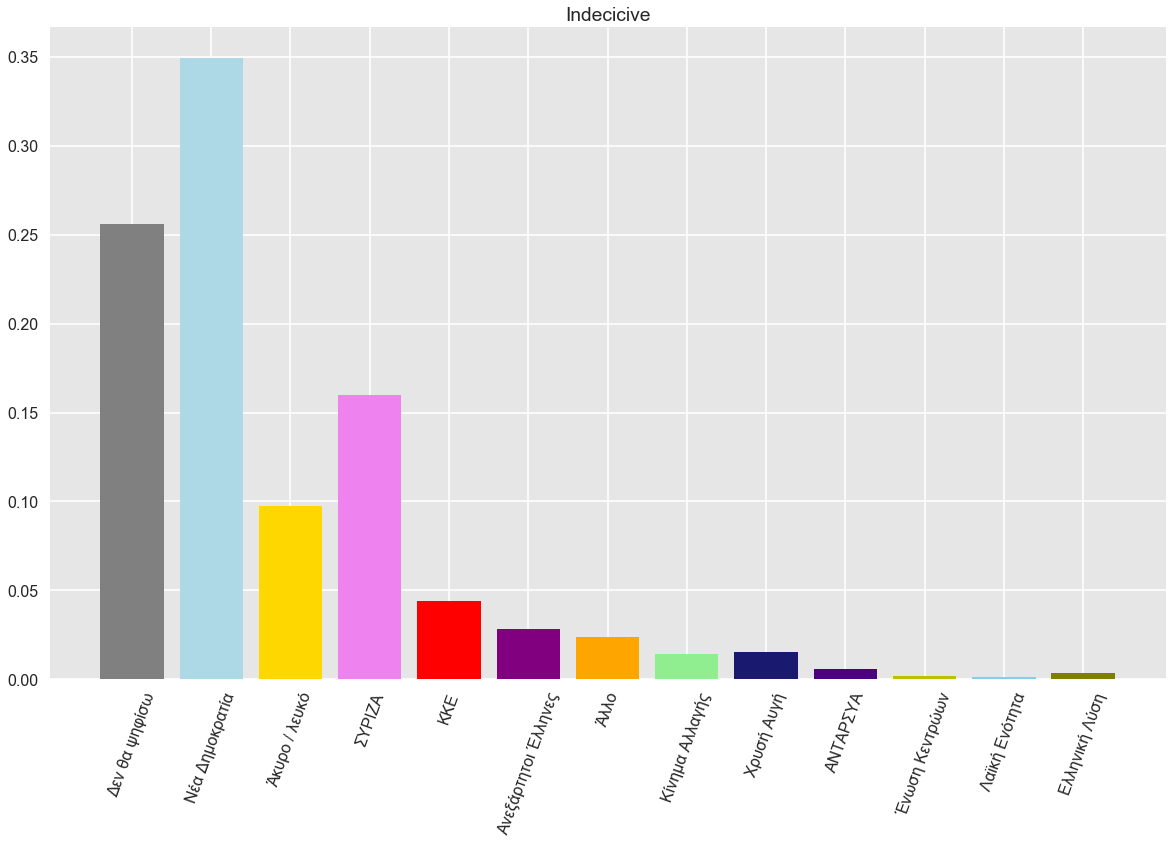

In [108]:
plt.figure(figsize=(20,12))
plt.title('Indecicive')    
color = 'gray','lightblue','gold', 'violet', 'r', 'purple', 'orange', 'lightgreen', 'midnightblue','indigo','y', 'skyblue', 'olive'
plt.bar(labels, sizes,color=color)
plt.xticks(labels, rotation=70)
plt.show()

In [63]:
count

Counter({'Νέα Δημοκρατία': 4742,
         'Δεν θα ψηφίσω': 1971,
         'Άκυρο / λευκό': 1107,
         'Χρυσή Αυγή': 270,
         'ΣΥΡΙΖΑ': 1573,
         'ΚΚΕ': 351,
         'Ανεξάρτητοι Έλληνες': 354,
         'Ελληνική Λύση': 4,
         'Κίνημα Αλλαγής': 45,
         'Άλλο': 155,
         'Πλεύση Ελευθερίας': 15,
         'ΑΝΤΑΡΣΥΑ': 24,
         'Ένωση Κεντρώων': 7,
         'Λαϊκή Ενότητα': 2})

In [64]:
df['election'].unique()

array(['Αναποφάσιστος', 'Άκυρο / λευκό', 'Χρυσή Αυγή', 'Νέα Δημοκρατία',
       'Κίνημα Αλλαγής', 'Δεν θα ψηφίσω', 'Λαϊκή Ενότητα', 'ΣΥΡΙΖΑ',
       'Άλλο', 'ΑΝΤΑΡΣΥΑ', 'Ανεξάρτητοι Έλληνες', 'ΚΚΕ', 'Ελληνική Λύση',
       'Ένωση Κεντρώων', 'Πλεύση Ελευθερίας'], dtype=object)

In [28]:
df['election'].describe()

count             33119
unique               15
top       Αναποφάσιστος
freq              10620
Name: election, dtype: object

In [29]:
df['election'].value_counts()

Αναποφάσιστος          10620
Νέα Δημοκρατία          6902
Δεν θα ψηφίσω           2977
ΚΚΕ                     2578
Κίνημα Αλλαγής          2412
Άκυρο / λευκό           2203
ΣΥΡΙΖΑ                  2071
Ανεξάρτητοι Έλληνες     1025
Χρυσή Αυγή               882
Άλλο                     515
Λαϊκή Ενότητα            290
ΑΝΤΑΡΣΥΑ                 282
Πλεύση Ελευθερίας        143
Ένωση Κεντρώων           135
Ελληνική Λύση             84
Name: election, dtype: int64

In [30]:
318/(1371-433)

0.3390191897654584

In [31]:
decisives['election'].value_counts()

11    6902
6     2977
8     2578
9     2412
0     2203
13    2071
5     1025
14     882
1      515
10     290
3      282
12     143
2      135
7       84
Name: election, dtype: int64